In [1]:
# Import necessary modules
import sys
import os

# Ensure the current directory (root folder) is in the Python module path
sys.path.append(os.getcwd())

import torch
import matplotlib.pyplot as plt

from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.dataset.rasterized import MazeDatasetConfig, MazeDataset, RasterizedMazeDataset

In [2]:
def get_device():
    """ Use CUDA or MPS if available, otherwise use CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

In [3]:
def get_mazes(maze_size=9, num_mazes=10, gen='dfs_perc', percolation=0.0, deadend_start=True):
    """ Generate mazes of the given size and number, 
        from the given dataset, and load to device"""
    
    assert maze_size % 2 == 1
    grid_n = (maze_size + 1) // 2
    
    # Generate base maze dataset
    if gen == 'dfs':
        maze_ctor = LatticeMazeGenerators.gen_dfs
        maze_ctor_kwargs = dict()
    elif gen == 'dfs_perc':
        maze_ctor = LatticeMazeGenerators.gen_dfs_percolation
        maze_ctor_kwargs = dict(p=percolation)
    elif gen == 'percolation':
        maze_ctor = LatticeMazeGenerators.gen_percolation
        maze_ctor_kwargs = dict(p=percolation)
    endpoint_kwargs=dict(deadend_start=deadend_start, 
                         endpoints_not_equal=True,
                         except_on_no_valid_endpoint=False)

    base_dataset = MazeDataset.from_config(
        MazeDatasetConfig(
            name='test',
            grid_n=grid_n,
            n_mazes=num_mazes,
            seed=42,
            maze_ctor=maze_ctor, 
            maze_ctor_kwargs=maze_ctor_kwargs,
            endpoint_kwargs=endpoint_kwargs
        ),
        gen_parallel = True,
        local_base_path='data/maze_dataset/',
    )

    # Generate rasterized maze dataset
    dataset = RasterizedMazeDataset.from_base_MazeDataset(
        base_dataset=base_dataset,
        added_params=dict(
            remove_isolated_cells=True,
            extend_pixels=True, # maps from 1x1 to 2x2 pixels and adds 3 padding
        )
    )

    dataset = dataset.get_batch(idxs=None)

    # Get inputs
    inputs = dataset[0,:,:,:]
    inputs = inputs / 255.0
    inputs = inputs.permute(0, 3, 1, 2)
    inputs = inputs.float().detach().to(get_device(), dtype=torch.float32)

    # Get solutions
    solutions = dataset[1,:,:, :]
    solutions = solutions / 255.0
    solutions = solutions.permute(0, 3, 1, 2)
    solutions, _ = torch.max(solutions, dim=1)
    solutions = solutions.float().detach().to(get_device(), dtype=torch.float32) 

    return inputs, solutions, base_dataset

/Users/brandon/Library/CloudStorage/Dropbox/Mac/Documents/maze-dataset/.venv/lib/python3.10/site-packages/muutils/json_serialize/serializable_dataclass.py:847: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([2, 0]), type(getattr(output, k)) = <class 'numpy.ndarray'>
end_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([1, 4]), type(getattr(output, k)) = <class 'numpy.ndarray'>
solution:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'coord row_col']'>, but got value getattr(output, k) = array([[2, 0],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4]]), type(getattr(output, k)) = <class 'numpy.ndarray'>
  on_typecheck_mismatch.process(
/Users/brandon/Library/CloudStorage/Dropbox/Mac/Documents/maze-dataset/.venv/lib/python3.10/site-packages/muutils/

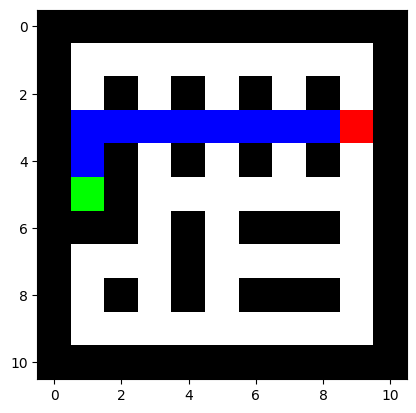

In [4]:
# Create percolated maze

inputs, solutions, base_dataset = get_mazes(
    maze_size=9, 
    num_mazes=10,
    percolation=0.8,
    deadend_start=True)

maze = base_dataset[0]
plt.imshow(maze.as_pixels());